- 금융 거래 데이터 분석
- 고객 신용 예측하는 분류모델

- 순서
    - 데이터 읽어오기
    - 데이터 정제
    - 데이터 시각화
    - 데이터 전처리
    - 모델 학습
    - 평가 및 예측
    - 불균형 class 데이터 처리

데이터셋
- UCI 데이터셋을 기반으로   
    https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data
- Kaggle에서 가공해놓은 데이터 사용(.csv)   
    https://www.kaggle.com/datasets/adityapotdar23/german-credit-data?resource=download


# 1. 데이터 읽어오기


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델
from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트
from sklearn.linear_model import LogisticRegression # 로지스틱회귀 분류모델
from sklearn.naive_bayes import GaussianNB          # 나이브 베이즈 분류기
from sklearn.svm import SVC                         # 서포트벡터머신 분류모델
from sklearn.tree import DecisionTreeClassifier     # 의사결정트리 분류모델
from xgboost import XGBClassifier                   # XGBoost 분류모델

# 평가지표
from sklearn.metrics import (
    accuracy_score,    # 정확도
    confusion_matrix,  # 혼동 행렬
    f1_score,          # F1 스코어 (설명력)
    precision_score,   # 정밀도
    recall_score       # 재현율
)

# 데이터 전처리
from imblearn.over_sampling import SMOTE   # 데이터 불균형 해결 (오버샘플링)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder # 데이터 전처리 스케일러, 범주형 변수 인코더

SEED = 2022

In [3]:
df_origin = pd.read_csv("./data/german_credit_data.csv", index_col = 0)

df_origin.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### 1994년 독일 특정 은행 예금을 가지고 있던 사람들의 데이터
- 타겟변수
    - Risk
        - Good
        - Bad
   
- 특성 변수들
    - Age: 나이
    - Sex: 성별
    - Job: 직업(직업 숙련도)
        - 0: 비숙련직/비거주자,
        - 1: 비숙련직/거주자,
        - 2: 숙련직,
        - 3: 전문직
    - Housing: 주거형태
        - own: 자가,
        - rent: 임대,
        - free: 정확하지 않음
   
    - Saving accounts: 저축 예금 잔고정도
    - Checking account: 당좌 예금 잔고 정도
    - Credit amount: 예금 보유랑(독일 마르크 기준)
    - Duration: 은행에 예금거치기간(월)
    - Purpose: 예금 보유 목적 (특정 물품 구매, 교육용, 휴가용)

In [5]:
df_origin.info() # 데이터프레임 정보 요약

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [6]:
df_origin.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


# 데이터 정제
- 결측치 처리
- 이상치 처리

In [8]:
df_origin.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

전체 데이터가 1000개밖에 되지 않아 400개정도의 데이터를 dropna()로 삭제하기에는 데이터가 너무 적다.   
그래서 결측치를 대체하는 기법을 사용한다.

In [9]:
df_origin['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [10]:
df_origin['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

둘 다 문자열 형식의 값이기 때문에 nan값은 Others로 채워넣는다.

In [11]:
df_clean = df_origin

# null값을 Others로 대체한다.
df_clean['Saving accounts'].fillna('Other', inplace=True)
df_clean['Checking account'].fillna('Other', inplace=True)


In [13]:
df_origin.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

# 3. 데이터 시각화

각 변수별 상관관계 한번에 확인 : seaborn - pairplot (중점은 Risk)

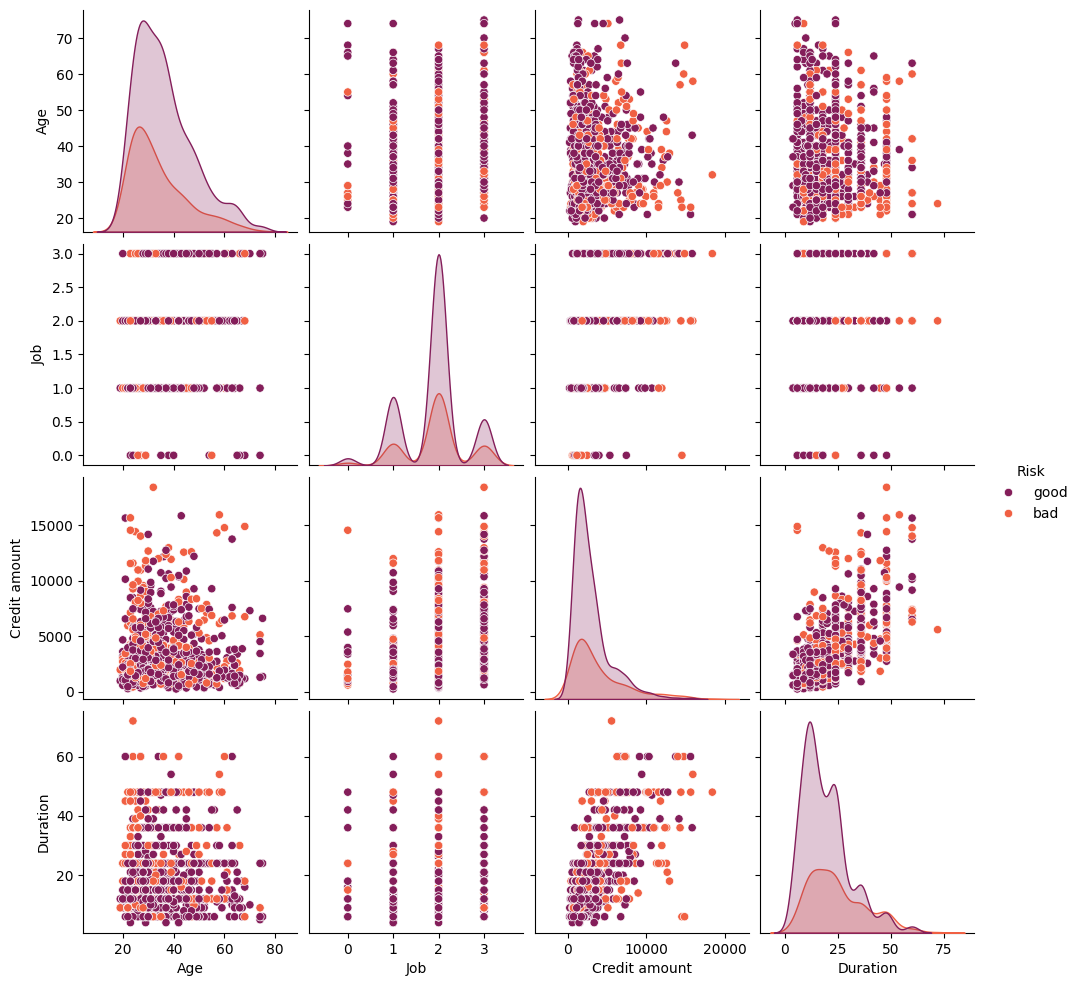

In [15]:
sns.pairplot(df_clean, palette='rocket', hue='Risk')

수치형 변수들만 확인되기 때문에, 수치형이 아닌 변수들은 전처리를 통해 수치형으로 변경해야 한다.

- 결과해석
    - Credit amount와 Duration은 미약하게 양의 상관관계가 있어보임.
    - Jobrhk Credit amount: Job이 전문화될수록(=3이 될수록) Credit amount가 많은 경우가 늘어난다.

<Axes: xlabel='Age', ylabel='Percent'>

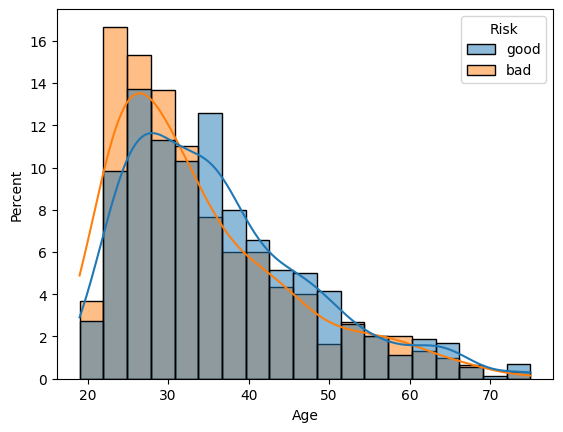

In [17]:
# Age 시각화 : Risk 별로 나이대 분포가 어떤지 확인
sns.histplot(
    df_clean,          # 데이터
    x='Age',           # 나이별
    kde=True,          # KDE 밀도곡선
    hue='Risk',        # 위험도
    stat='percent',    # 비율
    common_norm=False  # 그룹별 독립 정규화
)

상대적으로 저연령대(20대 초중반)에는 신용 위험도가 높은 경향이 있고, 반대로 30대 중반 이후에는 상대적으로 신용 위험도가 낮은 편인 것을 확인하였다.

<Axes: xlabel='Sex', ylabel='Percent'>

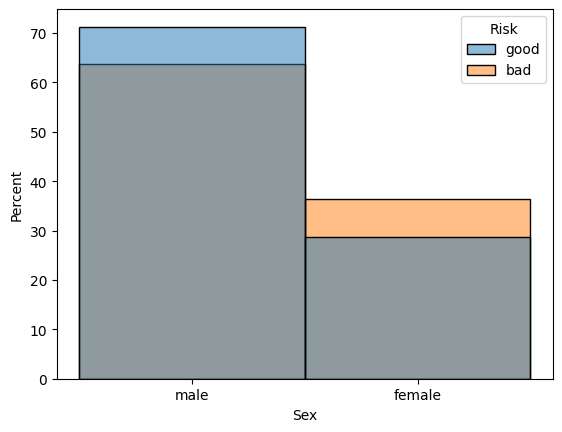

In [20]:
# 성별별 신용 위험도 확인
sns.histplot(
    df_clean,          # 데이터
    x='Sex',           # 성별별
    hue='Risk',        # 위험도
    stat='percent',    # 비율
    common_norm=False  # 그룹별 독립 정규화
)

미세하게 남자가 상대적으로 신용위험도가 낮은 비중이 조금 더 있었다.

<Axes: xlabel='Job', ylabel='Percent'>

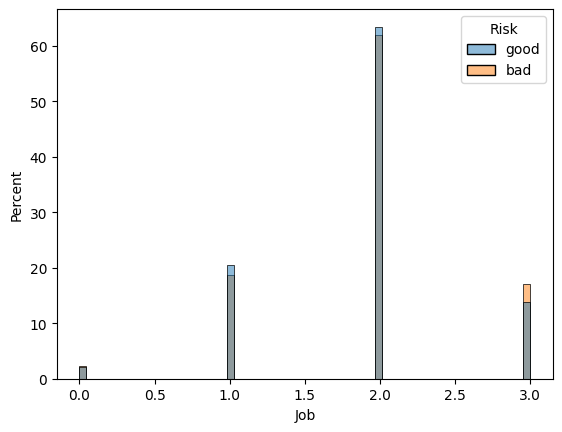

In [22]:
# Risk별 직업분포
sns.histplot(
    df_clean,
    x='Job',
    hue='Risk',
    stat='percent',
    common_norm=False
)

숙련직 (job 2)의 비중이 높다. 숙련직에서는 신용 위험도가 높은 비중이 살짝 더 높다.

<Axes: xlabel='Housing', ylabel='Percent'>

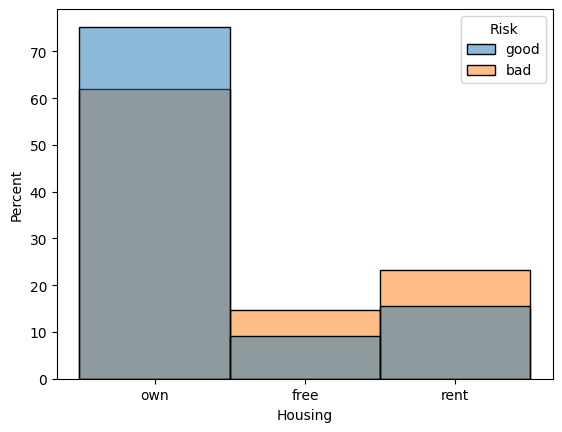

In [23]:
# Risk별로 주거 형태 분포
sns.histplot(
    df_clean,
    x='Housing',
    hue='Risk',
    stat='percent',
    common_norm=False
)

자가가 신용 위험도가 낮다.

<Axes: xlabel='Checking account', ylabel='Percent'>

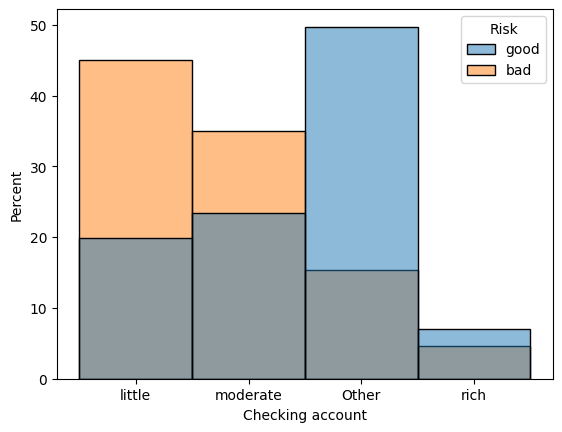

In [25]:
# Checking account
sns.histplot(df_clean, x='Checking account', hue='Risk',  stat='percent', common_norm=False)

Checking account와 Saving accounts   
잔고가 적으면 신용 위험도가 높다.   
잔고가 많으면 신용 위험도가 낮다.

<Axes: xlabel='Credit amount', ylabel='Percent'>

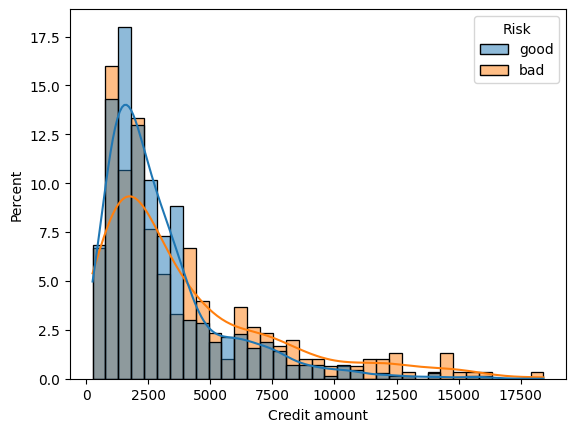

In [ ]:
# Credit amount
sns.histplot(df_clean, x='Credit amount',kde=True, hue='Risk',  stat='percent', common_norm=False)

<Axes: xlabel='Duration', ylabel='Percent'>

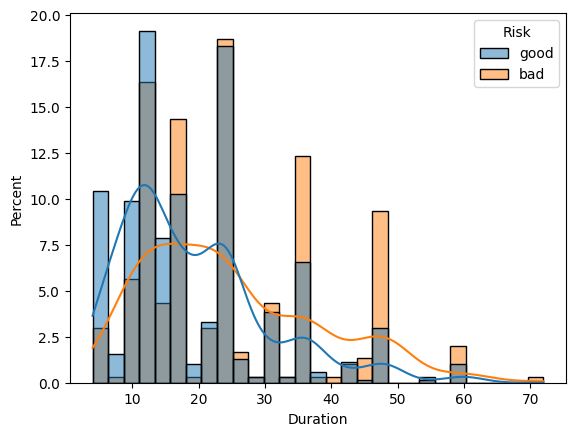

In [37]:
# Duration
sns.histplot(df_clean, x='Duration',kde=True, hue='Risk',  stat='percent', common_norm=False)

예치 기간이 긴 사람은 상대적으로 위험도가 높다.

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'radio/TV'),
  Text(1, 0, 'education'),
  Text(2, 0, 'furniture/equipment'),
  Text(3, 0, 'car'),
  Text(4, 0, 'business'),
  Text(5, 0, 'domestic appliances'),
  Text(6, 0, 'repairs'),
  Text(7, 0, 'vacation/others')])

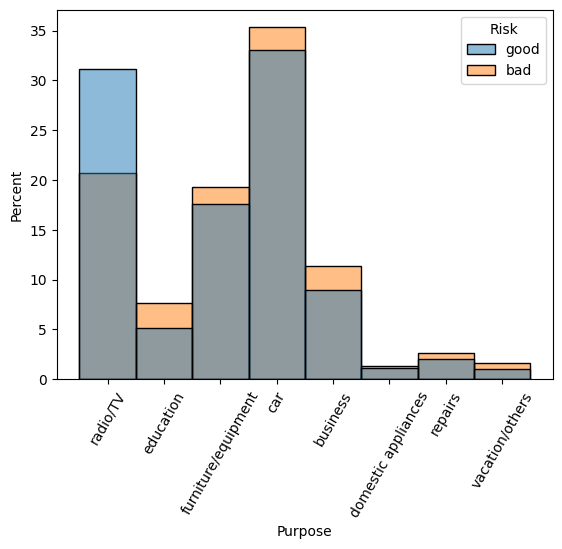

In [38]:
# Purpose 분포
sns.histplot(df_clean, x='Purpose', hue='Risk',  stat='percent', common_norm=False)
plt.xticks(rotation=60)

위험도가 낮은 사람들은 주로 라디오 TV, 자동차 등을 구매하는 목적으로 예금한다.   
위험도가 높은 사람은 자가용 마련 목적이 가장 큰 것을 볼 수 있다.

In [41]:
# 카테고리형 변수를 수치형 변수로 변환 (Sex, Housing, Saving accounts, Checking account, Purpose)
# OrdinalEncoder : 범주형 변수(문자)를 정수형으로 변환
ord_encoder = OrdinalEncoder(dtype=np.int32)

non_numeric_features = [
    "Sex",               # 성별
    "Housing",           # 주거형태
    "Saving accounts",   # 저축 계좌
    "Checking account",  # 당좌 예금
    "Purpose"            # 대출 목적
]

# ord_encoder.fit_transform: 범주형 변수들을 정수로 변환하여 데이터프레임에 반영
df_clean[non_numeric_features] = ord_encoder.fit_transform(df_clean[non_numeric_features])

df_clean

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,5,good
1,22,0,2,1,1,2,5951,48,5,bad
2,49,1,1,1,1,0,2096,12,3,good
3,45,1,2,0,1,1,7882,42,4,good
4,53,1,2,0,1,1,4870,24,1,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,1,0,1736,12,4,good
996,40,1,3,1,1,1,3857,30,1,good
997,38,1,2,1,1,0,804,12,5,good
998,23,1,2,0,1,1,1845,45,5,bad


범주형 변수들이 수치형 값으로 바뀌었다.

In [42]:
ord_encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['free', 'own', 'rent'], dtype=object),
 array(['Other', 'little', 'moderate', 'quite rich', 'rich'], dtype=object),
 array(['Other', 'little', 'moderate', 'rich'], dtype=object),
 array(['business', 'car', 'domestic appliances', 'education',
        'furniture/equipment', 'radio/TV', 'repairs', 'vacation/others'],
       dtype=object)]

인덱스로 확인한다. 예) female -> 0, male -> 1

In [43]:
# Risk도 수치형 변수로 변환한다. (good -> 0, bad -> 1)
df_clean['Risk'] = df_clean['Risk'].map({'good': 0, 'bad': 1})
df_clean

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,5,0
1,22,0,2,1,1,2,5951,48,5,1
2,49,1,1,1,1,0,2096,12,3,0
3,45,1,2,0,1,1,7882,42,4,0
4,53,1,2,0,1,1,4870,24,1,1
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,1,0,1736,12,4,0
996,40,1,3,1,1,1,3857,30,1,0
997,38,1,2,1,1,0,804,12,5,0
998,23,1,2,0,1,1,1845,45,5,1


Risk까지 최종 변환화였습니다.

### 학습, 테스트 데이터 분리
- X, y데이터를 만들어줘야 한다.

In [44]:
X = df_clean.drop('Risk', axis=1)  # 입력 데이터 X
X

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,0,1,1169,6,5
1,22,0,2,1,1,2,5951,48,5
2,49,1,1,1,1,0,2096,12,3
3,45,1,2,0,1,1,7882,42,4
4,53,1,2,0,1,1,4870,24,1
...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,1,0,1736,12,4
996,40,1,3,1,1,1,3857,30,1
997,38,1,2,1,1,0,804,12,5
998,23,1,2,0,1,1,1845,45,5


In [ ]:
y = df_clean['Risk']  # 타겟변수 y
y

0      0
1      1
2      0
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    0
Name: Risk, Length: 1000, dtype: int64

random_state : 컴퓨터는 완벽한 랜덤이 없기 때문에 난수처럼 보이는 수들을 하나씩 생성해주는 형태로 유사 난수 생성기를 사용한다.   
random_state 등을 사용합면 이 시작점을 고정시켜서 같은 결과가 나오도록 한다.

In [53]:
# train_test_split으로 데이터를 8:2 비율로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y         # 비율유지
)

In [51]:
print(
    f"신용도가 좋은 경우: {len(df_clean[df_clean['Risk'] == 0])}개\n"
    f"신용도가 나쁜 경우: {len(df_clean[df_clean['Risk'] == 1])}개"
)

신용도가 좋은 경우: 700개
신용도가 나쁜 경우: 300개


신용도가 좋은경우와 나쁜경우가 7:3인데, stratify 옵션을 주지 않으면 학습 및 테스트 데이터에는 이 비율대로 데이터가 분할되지 않는 경우가 있다.   
이걸 기존 데이터의 타겟 비율대로 맞춰주는 것이 stratify 옵션이다.

### 4-3. 정규화
- MinMaxScaler : 각 변수의 값을 0과 1사이의 값으로 반환한다.
- StandardScaler : 각 변수의 값을 평균이 0, 표준편차가 1인 값으로 반환한다.

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # 학습데이터로 정규화 기준을 학습하고 변환
X_test = scaler.transform(X_test)  # 테스트데이터는 학습데이터에서 구한 (최소/최대값)으로 변환 적용
X_test


array([[0.46428571, 1.        , 0.33333333, ..., 0.05570862, 0.08823529,
        0.14285714],
       [0.51785714, 1.        , 0.66666667, ..., 0.10238043, 0.07352941,
        0.14285714],
       [0.41071429, 0.        , 0.66666667, ..., 0.00732863, 0.11764706,
        0.71428571],
       ...,
       [0.28571429, 1.        , 1.        , ..., 0.19307913, 0.20588235,
        0.57142857],
       [0.32142857, 1.        , 0.33333333, ..., 0.0906987 , 0.11764706,
        0.57142857],
       [0.17857143, 0.        , 0.66666667, ..., 0.08910073, 0.11764706,
        0.14285714]], shape=(200, 9))

# 5. 모델학습
- Logistic Regression (분류모델)
    - y값 범위가 0 ~ 1 사이 (출력값을 바로 확률로 계산)
        - 시그모이드 함수 적용하면 임계점 0.5로 결정하면 0.5 이상은 1로, 0.5 이하는 0으로 판단한다.

In [55]:
lr_model = LogisticRegression(random_state=SEED)

lr_model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",2022
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

혼동행렬 (Confusion Matrix)
    - 실제로 1인것은 1로 예측해서 맞은경우 -> True Positive (TP)
    - 실제로 1인것은 0로 예측해서 틀린경우 -> False Negative (FN)
    - 실제로 0인것은 1로 예측해서 틀린경우 -> False Positive (FP)
    - 실제로 0인것은 0로 예측해서 맞은경우 -> True Negative (TN)

| | 예측 1 | 예측 0 |
| :---: | :---: | :---: |
| 실제 1 |   TP  |   FN  |
| 실제0 |   FP  |   TN  |

- 정확도 (보편적인 지표이지면 비율에 취약하다.)
    - Accuracy = TP + TN / (TP+FN+FP+TN)
    
       
- 정밀도: 모델이 Positive로 예측한 결과 중 실제로도 Positive인 것의 비율
    - 실제 Negative인 것을 Positive로 예측하면 곤란한 상황.    (예: 스팸메일 => 일반 메일을 스팸메일함에 넣어버림)
    - Precision = TP / TP+FP


- 재현율: 모델이 Positive로 예측한 결과 중 실제로도 Positive인 것의 비율
    - 실제 Positive인 것을 Negative로 예측하면 곤란한 상황. (예: 암 예측)
    - Recall = TP / TP+FN


- F1 Score: F-Score라고도 한다. PRecisionrhk Recall의 조화 평균
    - F1스코어 = 2 * (PRECISION * RECALL) / (PRECISION + RECALL) = 2TP / (2TP + FP + FN)

위 4가지 지표는 0 ~ 1 사이의 값이 나온다.   
1에 가까울수록 좋은 모델이다.
    
신용 위험도가 평가 데이터셋에서 중요한 지표를 따져보면 신용 위험도가 높은 사람한테 대출울 해주면 안된다.   
위험도가 높다 (Positive)인 사람을 위험도가 낮다(Negative)로 판단하면 안된다.(재현율)   
vs   
위험도가 낮은 (Negative)인 사람을 위험도가 높다(Positive)로 판단해서 대출이 안나오게 됐다 => 우수 고객이 불만을 가진다.

- => F1 스코어 (클래스 불균형 시에도 강하다.)   
일단 데이터셋이 타겟변수 비율이 7:3이기 때문에 클래스 불균형이 어느정도 있다고 봐야하고 F1스코어를 보는것이 확실히 좋다.

In [56]:
# 평가지표를 한번에 확인할 수 있는 함수
def check_metrics(model, model_name, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train) # 학습데이터 예측값 생성
    y_pred_test = model.predict(X_test)   # 테스트데이터 예측값 생성

    # 학습데이터 평가 지표 계산
    acc_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)

    # 테스트데이터 평가 지표 계산
    acc_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)

    print(f"훈련 데이터 정확도 : {acc_train:.6f}")
    print(f"훈련 데이터 정밀도 : {precision_train:.6f}")
    print(f"훈련 데이터 재현율 : {recall_train:.6f}")
    print(f"훈련 데이터 F1스코어 : {f1_train:.6f}")
    print()
    print(f"테스트 데이터 정확도 : {acc_test:.6f}")
    print(f"테스트 데이터 정밀도 : {precision_test:.6f}")
    print(f"테스트 데이터 재현율 : {recall_test:.6f}")
    print(f"테스트 데이터 F1스코어 : {f1_test:.6f}")

In [57]:
check_metrics(lr_model, "Logistic Regression", X_train, X_test, y_train, y_test)

훈련 데이터 정확도 : 0.707500
훈련 데이터 정밀도 : 0.544118
훈련 데이터 재현율 : 0.154167
훈련 데이터 F1스코어 : 0.240260

테스트 데이터 정확도 : 0.705000
테스트 데이터 정밀도 : 0.529412
테스트 데이터 재현율 : 0.150000
테스트 데이터 F1스코어 : 0.233766


실습 데이터의 Risk에서 0인 데이터와 1인 데이터의 비율이 7:3으로 1:1로 맞아떨어지지 않는다.   
즉 클래스 불균형 문제가 있다.   

일단은 모델문제일수도 있으니 다른 모델로 성능개선 여부를 확인한다.

- Naive Bayes 모델 사용
    - 조건부 확률을 사용한다.

In [59]:
nb_model = GaussianNB() # 나이브베이즈 모델의 일종인 Gaussian 나이브 베이즈 모델

nb_model.fit(X_train, y_train) # 학습데이터로 학습

check_metrics(nb_model, "Naive Bayes", X_train, X_test, y_train, y_test)

훈련 데이터 정확도 : 0.725000
훈련 데이터 정밀도 : 0.570423
훈련 데이터 재현율 : 0.337500
훈련 데이터 F1스코어 : 0.424084

테스트 데이터 정확도 : 0.710000
테스트 데이터 정밀도 : 0.527778
테스트 데이터 재현율 : 0.316667
테스트 데이터 F1스코어 : 0.395833


Logistic Regression 모델보다는 성능이 낫다.   
- SVM(Support Vector Machine)
    - 마진을 최대화시키는 서포트 벡터를 찾는다.
    - 마진을 최대화하는 이유는 주어진 데이터 뿐 아니라 나중에 생성되거나 들어올 새로운 데이터를 분류할 떄 오분류할 가능성을 최소화하기 위해서이다.

In [62]:
# 분류용 모델 SVC, 회귀용 모델은 SVR
svm_model = SVC(random_state=SEED)

# 학습데이터로 학습
svm_model.fit(X_train, y_train)

# 모델의 성능 출력
check_metrics(svm_model, 'SVM', X_train, X_test, y_train, y_test)

훈련 데이터 정확도 : 0.752500
훈련 데이터 정밀도 : 0.800000
훈련 데이터 재현율 : 0.233333
훈련 데이터 F1스코어 : 0.361290

테스트 데이터 정확도 : 0.745000
테스트 데이터 정밀도 : 0.714286
테스트 데이터 재현율 : 0.250000
테스트 데이터 F1스코어 : 0.370370


로지스틱 회귀보다는 좀 낫다. 그리고 나이브 베이즈보다는 살짝 못하다.   
- Decision Tree와 Random Forest모델
    - Decision Tree를 앙상블한 모델이 Random Forest이다.
    - 그래서 일반적으로 Random Forest가 일반화 성능이 좋다. (=테스트셋, 새로운 데이터에 강하다. = 과적합에 강하다.)

In [63]:
# Decision 트리 모델 불러온다.
dt_model = DecisionTreeClassifier(
    random_state=SEED
)

# 학습
dt_model.fit(X_train, y_train)

# 성능 평가
check_metrics(dt_model, 'Decision Tree', X_train, X_test, y_train, y_test)


훈련 데이터 정확도 : 1.000000
훈련 데이터 정밀도 : 1.000000
훈련 데이터 재현율 : 1.000000
훈련 데이터 F1스코어 : 1.000000

테스트 데이터 정확도 : 0.675000
테스트 데이터 정밀도 : 0.452830
테스트 데이터 재현율 : 0.400000
테스트 데이터 F1스코어 : 0.424779


결과는 과적합 (학습데이터로는 학습이 잘 되었지만, 테스트 데이터로는 성능이 잘 나오지 않음)


In [66]:
# RandomForest 모델 사용
rf_model = RandomForestClassifier(
    random_state=SEED
)

rf_model.fit(X_train, y_train)

check_metrics(rf_model, 'Random Forest', X_train, X_test, y_train, y_test)

훈련 데이터 정확도 : 1.000000
훈련 데이터 정밀도 : 1.000000
훈련 데이터 재현율 : 1.000000
훈련 데이터 F1스코어 : 1.000000

테스트 데이터 정확도 : 0.720000
테스트 데이터 정밀도 : 0.562500
테스트 데이터 재현율 : 0.300000
테스트 데이터 F1스코어 : 0.391304


Decision Tree와 Random Forest 이 두 모델은 SEED에 영향을 많이 받는 편이다.   
이 두 모델 뿐 아니라 데이터 자체가 적으면 (예: 1000개) 모든 모델이 SEED에 영향을 많이 받는다.   
   
성능을 끌어올리기 위해서는 데이터가 많아야 한다.
일반적으로 DEcision Tree 사용시에 불순도 계산에 지니계수를 사용하는데 이걸 엔트로피로 바꿔서 사용해볼 수 있다.

In [65]:
# Decision 트리 모델 불러온다.
dt_model = DecisionTreeClassifier(
    criterion='entropy',
    random_state=SEED
)

# 학습
dt_model.fit(X_train, y_train)

# 성능 평가
check_metrics(dt_model, 'Decision Tree', X_train, X_test, y_train, y_test)


훈련 데이터 정확도 : 1.000000
훈련 데이터 정밀도 : 1.000000
훈련 데이터 재현율 : 1.000000
훈련 데이터 F1스코어 : 1.000000

테스트 데이터 정확도 : 0.670000
테스트 데이터 정밀도 : 0.453125
테스트 데이터 재현율 : 0.483333
테스트 데이터 F1스코어 : 0.467742


In [70]:
# RandomForest 모델 사용
rf_model = RandomForestClassifier(
    criterion='entropy',
    random_state=SEED
)

rf_model.fit(X_train, y_train)

check_metrics(rf_model, 'Random Forest', X_train, X_test, y_train, y_test)

훈련 데이터 정확도 : 1.000000
훈련 데이터 정밀도 : 1.000000
훈련 데이터 재현율 : 1.000000
훈련 데이터 F1스코어 : 1.000000

테스트 데이터 정확도 : 0.765000
테스트 데이터 정밀도 : 0.696970
테스트 데이터 재현율 : 0.383333
테스트 데이터 F1스코어 : 0.494624


XGBoost 분류모델
- 성능이 좋은 앙상블 모델
- 내부적으로는 Tree기반(Decision Tree)를 앙상블해서 작동한다.

In [71]:
xgb_model = XGBClassifier(
    random_state=SEED
)

xgb_model.fit(X_train, y_train)

check_metrics(xgb_model, 'XGB Model', X_train, X_test, y_train, y_test)

훈련 데이터 정확도 : 1.000000
훈련 데이터 정밀도 : 1.000000
훈련 데이터 재현율 : 1.000000
훈련 데이터 F1스코어 : 1.000000

테스트 데이터 정확도 : 0.720000
테스트 데이터 정밀도 : 0.545455
테스트 데이터 재현율 : 0.400000
테스트 데이터 F1스코어 : 0.461538


### 6. 데이터 클래스 불균형 문제   
- 사용이유
  - 데이터 타겟 변수별 비율이 맞지 않으면 학습이 편향되게 된다.   
  (라벨이 많은 것은 잘 맞추는데, 라벨이 적은 데이터에 데해서는 잘 맞추지 못한다.)   
  그래서 클래스별 학습 데이터를 맞춰줌으로 인해 편향이 없도록 하는게 목적이다.
- 불균형 문제 해결시
  - 클래스가 적은 데이터 개수를 늘리는 Oversampling
  - 클래스가 많은 데이터의 개수를 줄이는 Undersampling

1000개 데이터이기 떄문에 Oversampling이 더 적당해보인다.   
기법은 SMOTE를 사용한다.

In [72]:
print(
    f"학습데이터에서 신용도가 좋은 경우: {(y_train == 1).sum()}"
    f"학습데이터에서 신용도가 나쁜 경우: {(y_train == 0).sum()}"
)

학습데이터에서 신용도가 좋은 경우: 240학습데이터에서 신용도가 나쁜 경우: 560


In [76]:
# SMOTE 객체를 만들어준다.
smote = SMOTE(
    random_state=SEED
)

# 학습 데이;터에 Oversampling을 적용한다.
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print(
    f"Oversampling 이전의 데이터 갯수: {X_train.shape[0]}\n"
    f"Oversampling 이전의 데이터 갯수: {X_train_over.shape[0]}"
)

Oversampling 이전의 데이터 갯수: 800
Oversampling 이전의 데이터 갯수: 1120


검증 데이터에는 Oversampling을 적용하지 않는다. 학습데이터만 적용해서 비율을 맞춰서 학습시켜주면 된다.

In [78]:
xgb_over_model = XGBClassifier(
    random_state = SEED
)

xgb_over_model.fit(X_train_over, y_train_over)

# 검증시에도 학습데이터는 오버샘플링 된 데이터로 검증한다.
check_metrics(xgb_over_model, "XGBoost width SMOTE", X_train_over, X_test, y_train_over, y_test)

훈련 데이터 정확도 : 1.000000
훈련 데이터 정밀도 : 1.000000
훈련 데이터 재현율 : 1.000000
훈련 데이터 F1스코어 : 1.000000

테스트 데이터 정확도 : 0.745000
테스트 데이터 정밀도 : 0.576271
테스트 데이터 재현율 : 0.566667
테스트 데이터 F1스코어 : 0.571429


- Decisiton Tree 단일로 사용 -> 일반화 성능이 낮음
- 앙상블 -> 분산을 억제 (=과적합 위험을 낮춤)

- 베깅 -> 병렬로 모델을 학습시키고, 결과를 다수결 또는 평균으로 내보낸다.
- 부스팅 -> 순차구조. 병렬을 직렬로 학습시키고, 결과를 마지막에 내보낸다. (점진적 성능 향상)
- 스태킹 -> 병렬로 모델을 학습시키고, 결과를 하나의 메타모델이 판단한다.